In [10]:
import os
import pandas as pd
import pm4py

Data Loading:

In [11]:
file_dir = '../data/'
file_name = 'Hospital_Billing_Eventlog.xes'
download_url = 'https://data.4tu.nl/file/6af6d5f0-f44c-49be-aac8-8eaa5fe4f6fd/28b83e72-375e-4da4-8459-a8506e898edf'
# Check if file exists and download it if not

# Check if directory exists
if not os.path.exists(file_dir):
    os.system("mkdir " + file_dir)
if not os.path.exists(file_dir + file_name):
    print('Downloading file...')
    os.system(f'wget -O {file_dir + file_name + ".gz"} {download_url}')
    os.system(f'gzip -d {file_dir + file_name + ".gz"}')


In [12]:
data = pm4py.read_xes(file_dir + file_name)
data = pm4py.format_dataframe(data)


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 100000/100000 [00:25<00:00, 3856.24it/s]


In [13]:
# Get overview over data
data
import copy

data2 = copy.deepcopy(data)


Preprocessing:

In [14]:
# print columns
data = data[['@@case_index', 'diagnosis', 'concept:name', 'isCancelled', 'isClosed']]
data

,@@case_index,diagnosis,concept:name,isCancelled,isClosed
0,0,A,NEW,False,True
1,0,NaN,FIN,NaN,NaN
2,0,NaN,RELEASE,NaN,NaN
3,0,NaN,CODE OK,NaN,NaN
4,0,NaN,BILLED,NaN,NaN
...,...,...,...,...,...
451354,99999,UE,NEW,False,True
451355,99999,NaN,FIN,NaN,NaN
451356,99999,NaN,RELEASE,NaN,NaN
451357,99999,NaN,CODE OK,NaN,NaN


In [15]:
# Save as new, smaller csv
data.to_csv('../data/preprocessed_data.csv', sep=';', index=False)

Feature Extraction:

In [16]:
# Overview over unique values for each column
print("Unique value oveview:\n")
print("======================")
print(data.nunique())
print("======================")

Unique value oveview:

@@case_index    100000
diagnosis         1192
concept:name        18
isCancelled          2
isClosed             2
dtype: int64


In [17]:
# Get traces
traces = data.groupby('@@case_index')['concept:name'].apply(tuple).reset_index().rename(columns={"concept:name": "Traces"})

In [ ]:
traces


In [18]:
# Get the value counts for each unique trace
trace_counts = traces['Traces'].value_counts()

# Convert to dictionary
trace_counts_dict = trace_counts.to_dict()


In [19]:
trace_counts_dict



{('NEW', 'CHANGE DIAGN', 'FIN', 'RELEASE', 'CODE OK', 'BILLED'): 33672,
 ('NEW',): 22373,
 ('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED'): 20901,
 ('NEW', 'DELETE'): 4813,
 ('NEW', 'FIN'): 3508,
 ('NEW',
  'CHANGE DIAGN',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 2121,
 ('NEW', 'CHANGE DIAGN', 'DELETE'): 1555,
 ('NEW', 'FIN', 'RELEASE', 'CODE NOK', 'BILLED'): 977,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'REOPEN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 869,
 ('NEW', 'FIN', 'RELEASE', 'CODE OK', 'BILLED', 'CODE OK'): 512,
 ('NEW', 'FIN', 'RELEASE', 'CODE NOK', 'EMPTY'): 400,
 ('NEW', 'FIN', 'RELEASE', 'BILLED'): 359,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED',
  'STORNO',
  'REJECT',
  'BILLED'): 314,
 ('NEW',
  'FIN',
  'RELEASE',
  'CODE OK',
  'REOPEN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED'): 273,
 ('NEW',
  'CHANGE DIAGN',
  'FIN',
  'RELEASE',
  'CODE OK',
  'BILLED',
  'STORNO',
  'REJECT

### Encoding using n-gram

In [20]:

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("../data/preprocessed_data.csv", sep=";")

# Drop the specified columns
df.drop(columns=['diagnosis', 'isCancelled', 'isClosed'], inplace=True)

# Rename the specified column
df.rename(columns={'@@case_index': 'case:concept:name'}, inplace=True)

print(df)
df.to_csv('out2.csv', index=False, sep=",")

# Function to clean values
def clean_values(value):
    if isinstance(value, str):
        value = value.replace(" ", "")
        if value == "JOIN-PAT":
            value = "JOINPAT"
    return value

# Apply the function to clean values in the DataFrame
df = df.applymap(clean_values)


def get_traces(df):
    traces, ids = [], []
    for group in df.groupby("case:concept:name"):
        events = list(group[1]["concept:name"])
        traces.append(" ".join(x for x in events))
        ids.append(group[0])
    return traces, ids


traces, ids = get_traces(df)
df = df.groupby('case:concept:name')['concept:name'].apply(tuple).reset_index().rename(columns={"concept:name": "Traces"})




def n_grams(traces):
    bi_traces, tri_traces = [], []
    for trace in traces:
        acts = trace.split(" ")
        
        bi_trace = ""
        for i in range(len(acts) - 1):
            bi_trace += acts[i] + "_" + acts[i + 1] + " "

        tri_trace = ""
        for i in range(len(acts) - 2):
            tri_trace += acts[i] + "_" + acts[i + 1] + "_" + acts[i + 2] + " "

        bi_traces.append(bi_trace)
        tri_traces.append(tri_trace)

    
   
    bi_gram = CountVectorizer().fit_transform(bi_traces).toarray()
  
    tri_gram = CountVectorizer().fit_transform(tri_traces).toarray()
   
    return bi_gram, tri_gram, bi_traces,tri_traces





bi_gram, tri_gram, bi_traces,tri_traces = n_grams(traces)


        case:concept:name concept:name
0                       0          NEW
1                       0          FIN
2                       0      RELEASE
3                       0      CODE OK
4                       0       BILLED
...                   ...          ...
451354              99999          NEW
451355              99999          FIN
451356              99999      RELEASE
451357              99999      CODE OK
451358              99999       BILLED

[451359 rows x 2 columns]


### Bi gram and Tri gram visualisation 

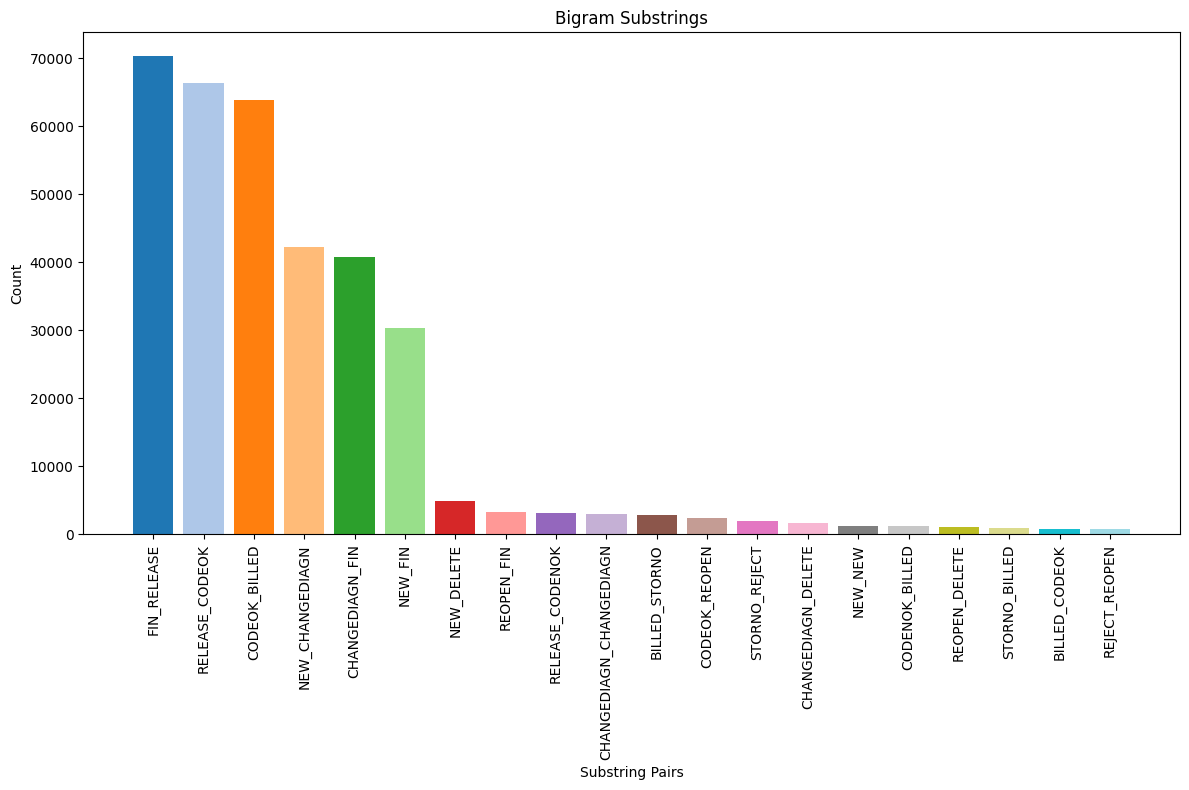

In [21]:


import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
# Function to split strings by spaces with the  separator being ' ' 
def split_by_backspace_separator(s):
    return s.split()

# Count the occurrences of each substring pair
substring_counter = Counter()

single_elements_counter = Counter()

for item in traces:
    substrings = split_by_backspace_separator(item)
    
    if len(substrings) == 0 or (len(substrings) == 1 and substrings[0] == ''):
        single_elements_counter[''] += 1
    else:
        for i in range(len(substrings) - 1):
            pair = f"{substrings[i]}_{substrings[i+1]}"
           
            substring_counter[pair] += 1
        if len(substrings) == 1 and substrings[0] != '':
            single_elements_counter[substrings[0]] += 1


# For including the length 1 or the length 2 itemsets:
#total_counter = substring_counter.update( single_elements_counter)


total_counter = substring_counter 
# Sort the pairs by their count
sorted_pairs = sorted(substring_counter.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_pairs)

# Generate a list of colors
colors = plt.cm.tab20(np.linspace(0, 1, len(labels[0:20])))
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(labels[0:20], values[0:20],color=colors)
plt.xlabel('Substring Pairs')
plt.ylabel('Count')
plt.title('Bigram Substrings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

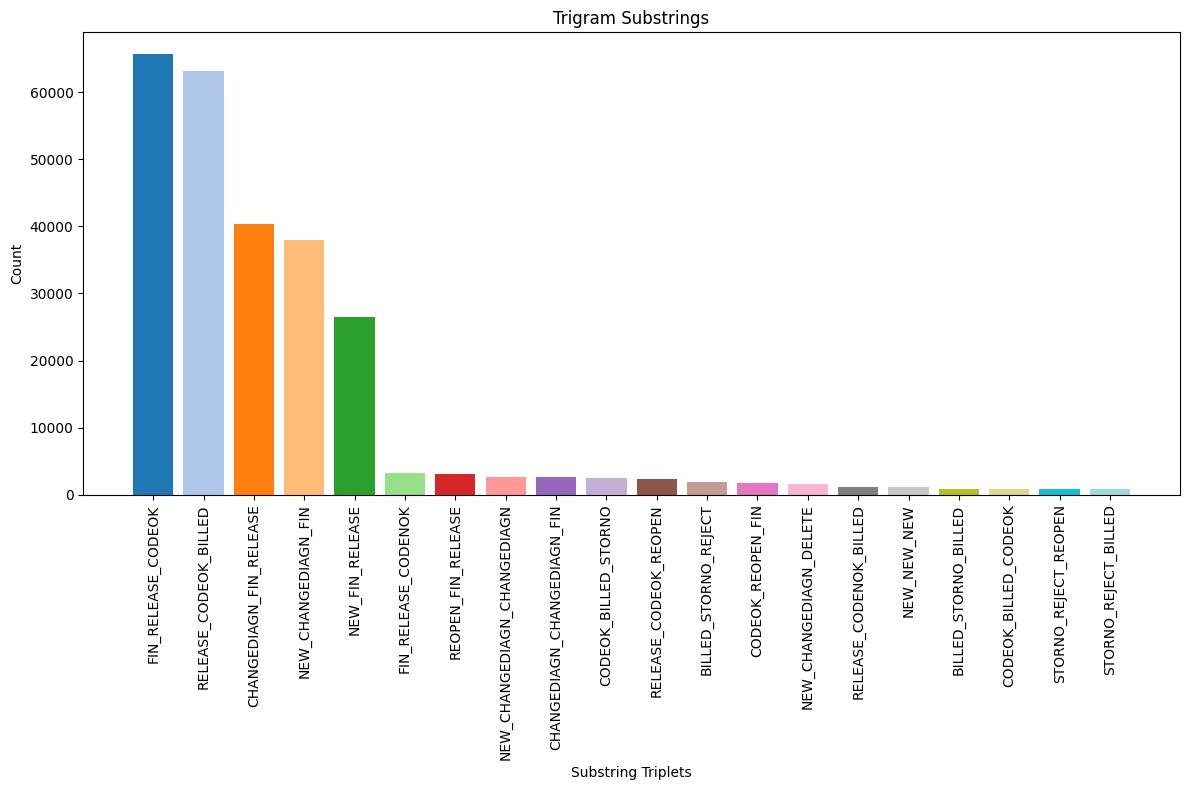

In [22]:


import matplotlib.pyplot as plt
from collections import Counter
# Function to split strings by spaces with the  separator being ' ' 
def split_by_backspace_separator(s):
    return s.split()

# Count the occurrences of each substring pair
substring_counter = Counter()

single_elements_counter = Counter()
#double_elements_counter = Counter()
for item in traces:
    substrings = split_by_backspace_separator(item)
    
    if len(substrings) == 0 or (len(substrings) == 1 and substrings[0] == ''):
        single_elements_counter[''] += 1
    else:
        for i in range(len(substrings) - 2):
            pair = f"{substrings[i]}_{substrings[i+1]}_{substrings[i+2]}"
            
            substring_counter[pair] += 1
       
        if len(substrings) == 1 and substrings[0] != '':
            single_elements_counter[substrings[0]] += 1


total_counter = substring_counter 
# Sort the pairs by their count
sorted_triplets = sorted(substring_counter.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_triplets)
colors = plt.cm.tab20(np.linspace(0, 1, len(labels[0:20])))
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(labels[0:20], values[0:20], color = colors)
plt.xlabel('Substring Triplets')
plt.ylabel('Count')
plt.title('Trigram Substrings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Clustering Algorithm K-Means:
1. Clustering of the traces based on bi-grams using K-Means

In [ ]:

from sklearn.cluster import KMeans
num_clusters = 2


kmeans = KMeans(n_clusters=num_clusters, random_state=1, n_init=20)
kmeans.fit(bi_gram)


df['Cluster'] = kmeans.labels_
df_sorted = df.sort_values(by='Cluster')
print(df_sorted)
df_sorted.to_csv('../data/n_grams_traces_k_means.csv', index=False)

cluster_sizes = df_sorted['Cluster'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {size} Traces")


Bi-gram Silhouette Coefficient and TSNE Visualization:

In [ ]:
from sklearn.metrics import silhouette_score,silhouette_samples

if len(set(kmeans.labels_)) > 1:  
    silhouette_avg = silhouette_score(bi_gram, kmeans.labels_)
    print(f"Silhouette Coefficient AVG: {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(bi_gram, kmeans.labels_)
    for i in range(len(set(kmeans.labels_)) - 1):  
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
        print(f"Silhouette Coefficient for cluster {i}: {np.mean(ith_cluster_silhouette_values)}")
else:
    print("Only one cluster found. No Silhouette Coefficient.")




from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, perplexity=30, n_iter=700)
tsne_result = tsne.fit_transform(bi_gram)
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()



Bi-gram Petri nets

In [ ]:

import pm4py
import pandas as pd
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.visualization.petri_net import visualizer as pm4pyvis

def create_event_log(traces):
    log = EventLog()
    if type(traces[0])== str:
        
        traces = list(map(eval, traces))
        
    for trace_tuple in traces:
        trace = Trace()
        for event_name in trace_tuple:
            event = Event({"concept:name": event_name})
            trace.append(event)
        log.append(trace)
    return log

df_sorted['Count'] = df.groupby('Traces')['Traces'].transform('count')

clusters = df_sorted


drop_list = ["case:concept:name", "time:timestamp"]
thisFilter = clusters.filter(drop_list)
clusters.drop(columns=thisFilter, inplace=True, axis=1)

clusters = df_sorted.groupby('Cluster')
for cluster_id, group in clusters:
    traces = group['Traces'].repeat(group['Count']).tolist()
    
    event_log = create_event_log(traces)
    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)
    gviz = pm4pyvis.apply(net, initial_marking, final_marking)
    gviz.graph_attr['label'] = f'Cluster {cluster_id}'
    gviz.graph_attr['labelloc'] = 't'
    gviz.graph_attr['fontsize'] = '20'
    pm4pyvis.view(gviz)


2. Clustering of the traces based on tri-grams using K-Means

In [ ]:
from sklearn.cluster import KMeans
num_clusters = 2


kmeans = KMeans(n_clusters=num_clusters, random_state=1, n_init=20)
kmeans.fit(tri_gram)


df['Cluster'] = kmeans.labels_
df_sorted = df.sort_values(by='Cluster')
print(df_sorted)
df_sorted.to_csv('../data/n_grams_traces_k_means.csv', index=False)

cluster_sizes = df_sorted['Cluster'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {size} Traces")


Tri-gram Interpretation and Visualization:

In [ ]:
from sklearn.metrics import silhouette_score,silhouette_samples

if len(set(kmeans.labels_)) > 1:  
    silhouette_avg = silhouette_score(tri_gram, kmeans.labels_)
    print(f"Silhouette Coefficient AVG: {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(tri_gram, kmeans.labels_)
    for i in range(len(set(kmeans.labels_)) - 1):  
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
        print(f"Silhouette Coefficient for cluster {i}: {np.mean(ith_cluster_silhouette_values)}")
else:
    print("Only one cluster found. No Silhouette Coefficient.")




from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, perplexity=30, n_iter=700)
tsne_result = tsne.fit_transform(tri_gram)
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()






Tri-gram Petri nets

In [ ]:

import pm4py
import pandas as pd
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.visualization.petri_net import visualizer as pm4pyvis

def create_event_log(traces):
    log = EventLog()
    if type(traces[0])== str:
        
        traces = list(map(eval, traces))
        
    for trace_tuple in traces:
        trace = Trace()
        for event_name in trace_tuple:
            event = Event({"concept:name": event_name})
            trace.append(event)
        log.append(trace)
    return log

df_sorted['Count'] = df.groupby('Traces')['Traces'].transform('count')

clusters = df_sorted


drop_list = ["case:concept:name", "time:timestamp"]
thisFilter = clusters.filter(drop_list)
clusters.drop(columns=thisFilter, inplace=True, axis=1)

clusters = df_sorted.groupby('Cluster')
for cluster_id, group in clusters:
    traces = group['Traces'].repeat(group['Count']).tolist()
    
    event_log = create_event_log(traces)
    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)
    gviz = pm4pyvis.apply(net, initial_marking, final_marking)
    gviz.graph_attr['label'] = f'Cluster {cluster_id}'
    gviz.graph_attr['labelloc'] = 't'
    gviz.graph_attr['fontsize'] = '20'
    pm4pyvis.view(gviz)
